# Let's start with updating all the test results summary files.


In [3]:
from data.utils import save_summary_file, save_bora_metrics_summary_file, save_summary_actions_file
import os
from utils import get_experiment_from_name


def recalculate_summary_file(
    data_dir: str,
    experiment_name: str,
    exclude_model: str = "LAEA_5",
):
    """Recalculate the summary file for a given experiment.

    Parameters
    ----------
        data_folder (str): path to the data folder
        experiment_name (str): name of the experiment
        exclude_model (str): model to exclude from generating a summary file
    """

    # Get the experiment folder
    experiment_dir = os.path.join(data_dir, experiment_name)

    # Check if the experiment folder exists
    if not os.path.exists(experiment_dir):
        print(f"No experiment folder found for {experiment_name}")
        return

    # Get experiment optimum
    _experiment_name, dim = experiment_name.split("_d")
    dim = int(dim)
    experiment = get_experiment_from_name(_experiment_name, dim)
    xopt, yopt = experiment.optimum

    # Find the test cases for the experiment
    models = [
        f for f in os.listdir(experiment_dir) if
        os.path.isdir(os.path.join(experiment_dir, f)) and f != exclude_model
    ]

    # Plot the results
    for model in models:
        model_data_dir = os.path.join(data_dir, experiment_name, model)

        # Recalculate the summary file
        save_summary_file(
            model_data_dir,
            experiment_name,
            yopt,
        )

        if model == "BORA":
            save_summary_actions_file(model_data_dir, experiment_name)
            save_bora_metrics_summary_file(model_data_dir, experiment_name)

In [4]:
experiments_labels = [
    ("Solar Energy Production_d4", "Energy Output (kWh)"),
    ("Projectile_d7", "Score (0-100)"),
    ("Greenhouse Biomass Production_d8", "TAGP (kg/ha)"),
    ("Photocatalytic Hydrogen Production_d10", "HER (µmol/gh)"),
    ("Levy_d10", "y"),
    ("Ackley_d15", "y"),
]
data_dir = os.path.join("data", "main_results")

for experiment, _ in experiments_labels:
    recalculate_summary_file(data_dir, experiment)


# Now looking at how BORA explores the search space for Branin (2D)


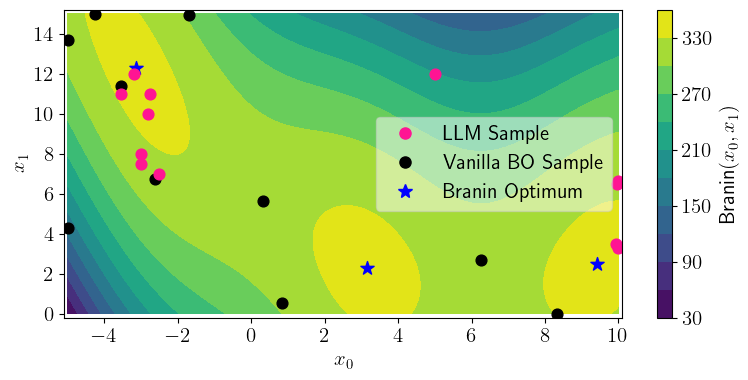

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.lines as mlines


def use_latex_font():
    """Use LaTeX for the plots"""
    try:
        plt.rcParams.update({"text.usetex": True})
    except:
        pass


use_latex_font()

experiment = get_experiment_from_name("Branin", 2)

# --------------------------------- Let's plot the Branin function first
# Create a grid of points
n = 200
x = np.linspace(experiment.lb[0], experiment.ub[0], n)
y = np.linspace(experiment.lb[1], experiment.ub[1], n)
X, Y = np.meshgrid(x, y)

# Evaluate the function at each point on the grid
samples = np.array([X.ravel(), Y.ravel()]).T
Z = experiment(samples)
Z = Z.reshape((n, n))

# Create the contour plot
font_size = 15
plt.figure(figsize=(9, 4))
contour = plt.contourf(X, Y, Z, levels=10, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.ax.tick_params(labelsize=font_size)

# Add labels
plt.xlabel('$x_{0}$', fontsize=font_size)
plt.ylabel('$x_{1}$', fontsize=font_size)
cbar.set_label('Branin$(x_{0}, x_{1})$', fontsize=font_size)

# Add the optimum point
xopt = experiment.optimum[0]
for i, (x, y) in enumerate(xopt):
    plt.scatter(x, y, color="blue", marker="*", s=100)

# --------------------------------- Now let's plot the points from the BORA run
experiment_name = f"{experiment.name}_d{experiment.dim}"
seed = 0
experiment_dir = os.path.join(data_dir, experiment_name, "BORA")
run_file_path = os.path.join(experiment_dir,
                             f"data_{experiment_name}_s{seed}.csv")
data = pd.read_csv(run_file_path)
X = data[["x_0", "x_1"]].values
Y = data["target"].values
hypotheses = data["hypotheses"].values

# Now scatter plot with annotations point number
colors = ["deeppink" if h is not np.nan else "black" for h in hypotheses]

for i, (x, y) in enumerate(X):
    plt.scatter(x, y, color=colors[i], marker="o", s=60)

# Create custom legend handles
llm_dot = mlines.Line2D([], [],
                        color='deeppink',
                        marker='o',
                        linestyle='None',
                        markersize=8,
                        label="LLM Sample")
bo_dot = mlines.Line2D([], [],
                       color='black',
                       marker='o',
                       linestyle='None',
                       markersize=8,
                       label="Vanilla BO Sample")
optimum_dot = mlines.Line2D([], [],
                            color='blue',
                            marker='*',
                            linestyle='None',
                            markersize=10,
                            label='Branin Optimum')
plt.legend(
    handles=[llm_dot, bo_dot, optimum_dot],
    framealpha=0.5,
    #    loc='upper right',
    fontsize=font_size)

# plt.xlabel('X-axis', fontsize=font_size)
plt.xlim(experiment.lb[0] - 0.1, experiment.ub[0] + 0.1)
plt.xticks(fontsize=font_size)

# plt.ylabel('Y-axis', fontsize=font_size)
plt.ylim(experiment.lb[1] - 0.2, experiment.ub[1] + 0.2)
plt.yticks(fontsize=font_size)

plt.show()

## Taking at a closer look at how the LLM influence the optimization


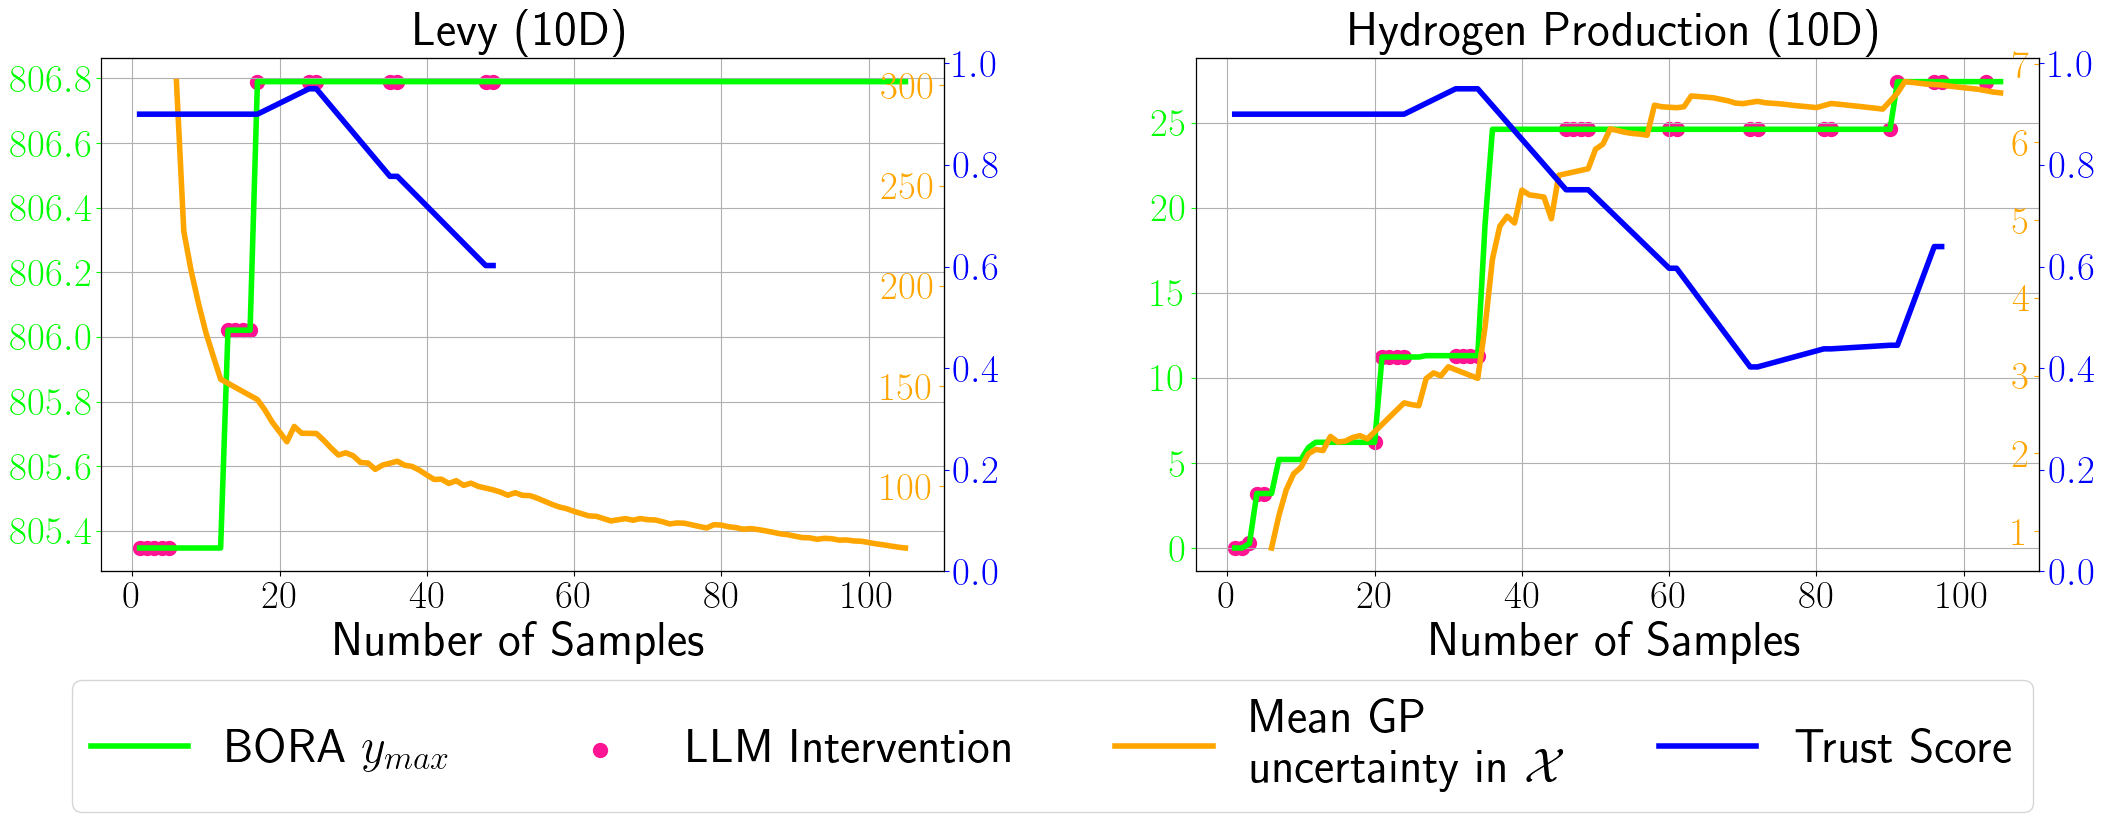

In [6]:
from typing import List, Tuple

# Rename experiments for better readability for the paper.
RENAMES = {
    "Greenhouse Biomass Production_d8": "Sugar Beet Production_d8",
    "Projectile_d7": "Petanque_d7",
    "Photocatalytic Hydrogen Production_d10": "Hydrogen Production_d10",
}


def plot_llm_influence_seed(experiments_seeds: List[Tuple[str, int]],
                            data_dir: str = "data"):
    # Get number of experiments
    num_experiments = len(experiments_seeds)

    # Prepare the plot.
    fig, axs = plt.subplots(1, num_experiments, figsize=(25, 9))
    line_width = 4
    marker_size = 100
    font_size = 35

    for i, (experiment_name, seed) in enumerate(experiments_seeds):
        # Get the experiment folder
        experiment_dir = os.path.join(data_dir, experiment_name, "BORA")

        # ------------------------------------------------ BORA best so far ------------------------------------------------
        summary_run_file_path = os.path.join(experiment_dir,
                                             f"summary_{experiment_name}.csv")
        summary_data_df = pd.read_csv(summary_run_file_path)
        bora_bsf = summary_data_df[str(seed)]
        iterations = summary_data_df["iteration"]
        # ----- Add to the plot
        axs[i].plot(
            iterations,
            bora_bsf,
            label="BORA $y_{max}$",
            color="lime",
            linewidth=line_width,
        )
        axs[i].set_xlabel("Number of Samples")
        axs[i].tick_params(axis='y', colors='lime')

        # ------------------------------------------------ Uncertainty ------------------------------------------------
        bora_metric_file_path = os.path.join(
            experiment_dir, f"summary_bora_metrics_{experiment_name}.csv")
        bora_metric_data_df = pd.read_csv(bora_metric_file_path)
        filtered_data = bora_metric_data_df[
            bora_metric_data_df[f"uncertainty_{seed}"].notna()]
        uncertainty_iterations = filtered_data["iteration"].tolist()
        uncertainty_values = filtered_data[f"uncertainty_{seed}"].tolist()
        # ---- Add to the plot as a second y-axis placed on the left
        ax2 = axs[i].twinx()

        ax2.plot(uncertainty_iterations,
                 uncertainty_values,
                 label="Mean GP \n uncertainty in $\mathcal{X}$",
                 color="orange",
                 linewidth=line_width)
        ax2.tick_params(axis='y', colors='orange')
        # Shift the secondary y-axis to the left
        ax2.spines['left'].set_position(
            ('outward', -607))  # Adjust outward position
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()
        ax2.spines['left'].set_visible(True)
        ax2.spines['right'].set_visible(False)

        # ------------------------------------------------ LLM Interventions as a scatter plot -----------------------------
        filtered_data = bora_metric_data_df[
            bora_metric_data_df[f"trust_score_{seed}"].notna()
            & (bora_metric_data_df[f"trust_score_{seed}"] != "FAILED")]
        intervention_iterations = filtered_data["iteration"].tolist()

        corresponding_targets = summary_data_df.loc[
            summary_data_df["iteration"].isin(intervention_iterations),
            str(seed)]
        # ---- Add to the plot
        axs[i].scatter(intervention_iterations,
                       corresponding_targets,
                       color="deeppink",
                       s=marker_size,
                       label="LLM Intervention")

        # ------------------------------------------------ Failed LLM Interventions as a scatter plot ---------------------
        filtered_data = bora_metric_data_df[
            bora_metric_data_df[f"trust_score_{seed}"] == "FAILED"]
        if not filtered_data.empty:
            failed_iterations = filtered_data["iteration"].tolist()
            corresponding_targets = summary_data_df.loc[
                summary_data_df["iteration"].isin(failed_iterations),
                str(seed)]
            # ---- Add to the plot
            axs[i].scatter(
                failed_iterations,
                corresponding_targets,
                color="deeppink",
                s=marker_size,
                # label="Failed LLM\nIntervention"
            )

        # ------------------------------------------------ Trust scores as a third y-axis -------------------------------
        # ---- Add to the plot as a second y-axis
        filtered_data = bora_metric_data_df[
            bora_metric_data_df[f"trust_score_{seed}"].notna()
            & (bora_metric_data_df[f"trust_score_{seed}"] != "FAILED")]
        trust_iterations = filtered_data["iteration"].tolist()
        trust_scores = filtered_data[f"trust_score_{seed}"].tolist()
        trust_scores = [float(score) for score in trust_scores]
        ax3 = axs[i].twinx()
        ax3.plot(trust_iterations,
                 trust_scores,
                 label="Trust Score",
                 color="blue",
                 linewidth=line_width)
        # Color y axis and the ticks in blue
        ax3.set_ylim(0, 1.01)
        ax3.tick_params(axis='y', colors='blue')

        # Title
        experiment_name = experiment_name if experiment_name not in RENAMES else RENAMES[
            experiment_name]
        experiment_name, dim = experiment_name.split("_d")
        title = f"{experiment_name} ({dim}D)"
        axs[i].set_title(title)
        axs[i].grid()

        # Increase the font size
        for item in (axs[i].get_xticklabels() + axs[i].get_yticklabels() +
                     ax2.get_yticklabels() + ax3.get_yticklabels()):
            item.set_fontsize(int(0.8 * font_size))

        for item in [axs[i].xaxis.label, axs[i].title]:
            item.set_fontsize(font_size)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    # Collect handles and labels
    handles, labels = [], []
    for ax in axs.flat:
        for handle, label in list(zip(*ax.get_legend_handles_labels())) + list(
                zip(*ax2.get_legend_handles_labels())) + list(
                    zip(*ax3.get_legend_handles_labels())):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    # Create a single legend
    fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=font_size)

    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.31)

    plt.show()


plot_llm_influence_seed(
    experiments_seeds=[("Levy_d10", 3),
                       ("Photocatalytic Hydrogen Production_d10", 1)],
    data_dir=data_dir,
)

# Experiment Main Results

## We are going to analyze the experiment results.


For each experiment, let's now plot the performance of each model.


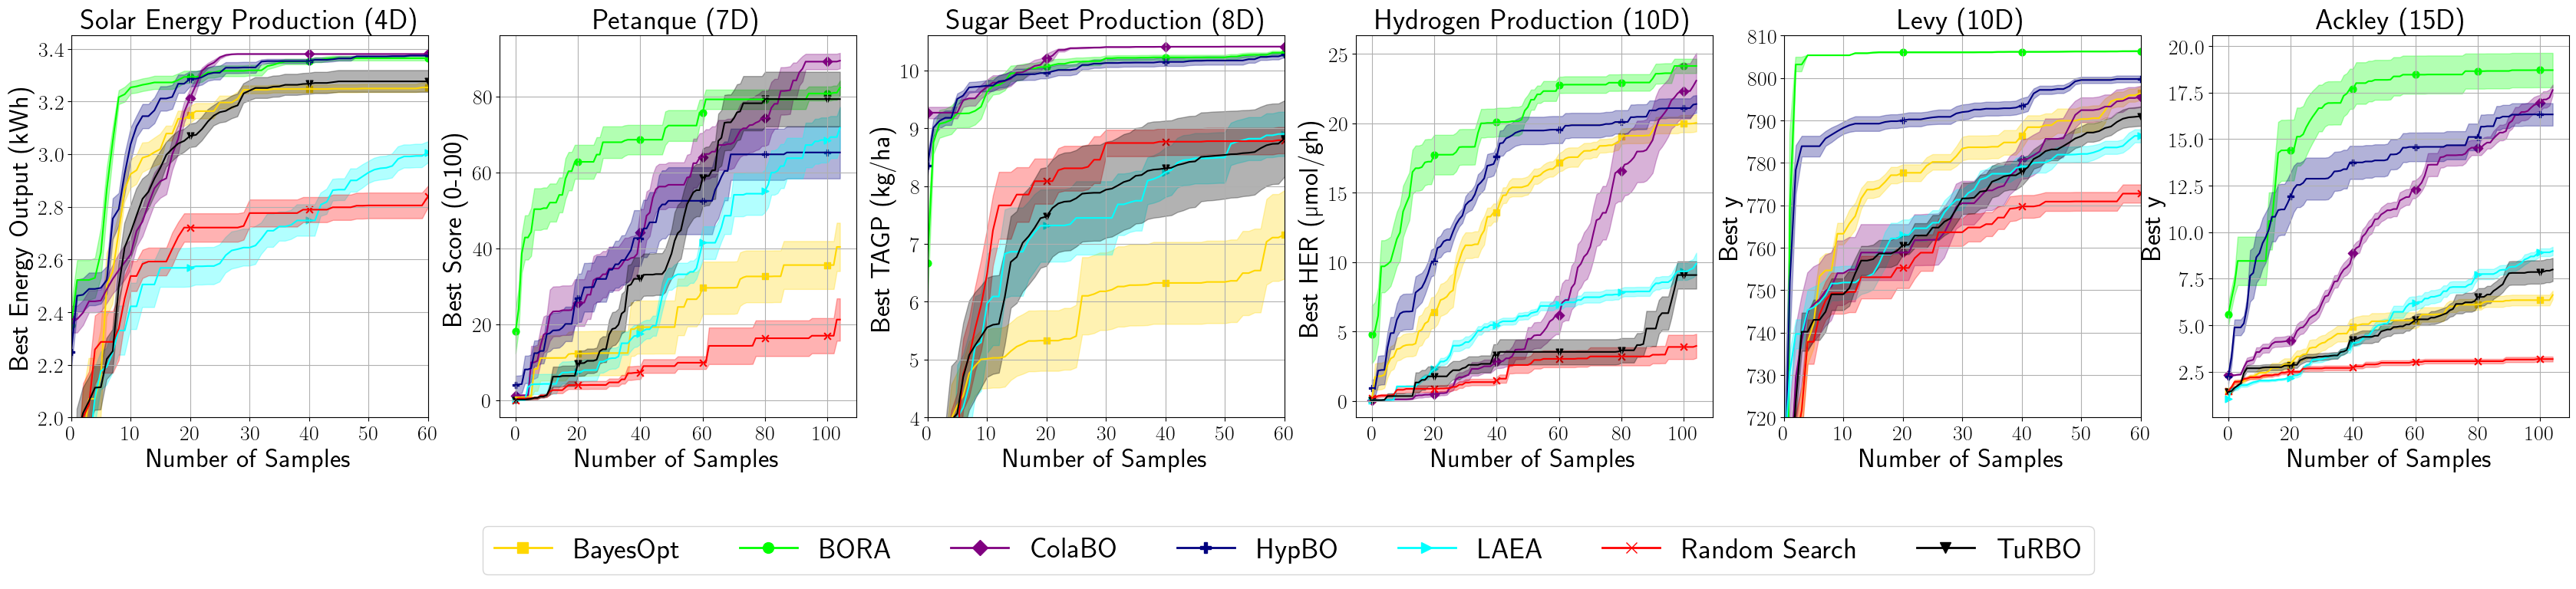

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

from typing import List, Tuple

# Define the style for the plots
STYLE_DICT = {
    "BORA": {
        "color": "lime",
        "marker": "o",
    },
    "BayesOpt": {
        "color": "gold",
        "marker": "s",
    },
    "TuRBO": {
        "color": "black",
        "marker": "v",
    },
    "Random Search": {
        "color": "red",
        "marker": "x",
    },
    "ColaBO": {
        "color": "purple",
        "marker": "D",
    },
    "HypBO": {
        "color": "navy",
        "marker": "P",
    },
    "LAEA": {
        "color": "cyan",
        "marker": ">",
    },
    "LAEA_5": {
        "color": "brown",
        "marker": "^",
    },
    "LLM-Only": {
        "color": "orange",
        "marker": "<",
    },
}


def plot_data(
    ax,
    data_folder,
    experiment_name,
    color,
    marker,
    limit: bool = False,
):
    # Read summary file
    summary_file = os.path.join(data_folder, f"summary_{experiment_name}.csv")
    data = pd.read_csv(summary_file)

    # Plot the mean data with the label
    ax.plot(
        data.index,
        data["mean_target"],
        color=color,
    )

    # Plot the markers without the label
    step = 20
    ax.scatter(
        data.index[::step],
        data["mean_target"][::step],
        marker=marker,
        s=40,
        color=color,
    )

    # Plot the standard deviation
    ax.fill_between(data.index,
                    data["mean_target"] - data["std_target"] / 4,
                    data["mean_target"] + data["std_target"] / 4,
                    alpha=0.3,
                    color=color)

    # Limits
    if limit:
        if "Levy" in experiment_name:
            ax.set_ylim(720, 810)
            ax.set_xlim(0, 60)
        elif "Solar Energy Production" in experiment_name:
            ax.set_ylim(2, 3.45)
            ax.set_xlim(0, 60)
        elif "Greenhouse" in experiment_name:
            ax.set_ylim(4, 10.6)
            ax.set_xlim(0, 60)


def plot_results(experiments: List[Tuple[str, str]],
                 data_folder_path: str = "data",
                 exclude_models: List[str] = ["LAEA_5"],
                 limit: bool = False):

    # Prepare ax with a single row and multiple columns
    fig, axs = plt.subplots(1,
                            len(experiments),
                            figsize=(7 * len(experiments), 8.3))  # 6.1
    # Ensure axs is always an array
    axs = np.atleast_1d(axs)

    font_size = 25

    # Record the models that are found for the legend creation
    found_models = []
    for i, (experiment_name, label) in enumerate(experiments):
        # Get the experiment folder
        experiment_folder = os.path.join(data_folder_path, experiment_name)

        # Check if the experiment folder exists
        if not os.path.exists(experiment_folder):
            print(f"No experiment folder found for {experiment_name}")
            continue

        # Find the models applied for the experiment
        models = [
            f for f in os.listdir(experiment_folder)
            if os.path.isdir(os.path.join(experiment_folder, f))
            and f not in exclude_models
        ]

        # Plot the results
        for model in models:
            if model not in STYLE_DICT:
                print(f"Model {model} not in style_dict")
                continue
            data_folder = os.path.join(
                data_folder_path,
                experiment_name,
                model,
            )
            color = STYLE_DICT[model]["color"]
            marker = STYLE_DICT[model]["marker"]

            # Check if summary file exists
            summary_file = os.path.join(data_folder,
                                        f"summary_{experiment_name}.csv")
            if not os.path.exists(summary_file):
                print(
                    f"No summary file found for {experiment_name} and {model}")
                continue

            # Add the model to the found models
            if model not in found_models:
                found_models.append(model)

            # Plot the data
            plot_data(
                axs[i],
                data_folder,
                experiment_name,
                color,
                marker,
                limit,
            )

        axs[i].set_xlabel("Number of Samples")
        axs[i].set_ylabel(f"Best {label}")

        # Title
        experiment_name = experiment_name if experiment_name not in RENAMES else RENAMES[
            experiment_name]
        experiment_name, dim = experiment_name.split("_d")
        title = f"{experiment_name} ({dim}D)"
        axs[i].set_title(title)

        axs[i].grid()

        # Increase the font size
        for item in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            item.set_fontsize(int(font_size * 0.8))

        for item in [axs[i].xaxis.label, axs[i].yaxis.label]:
            item.set_fontsize(font_size)

        axs[i].title.set_fontsize(int(1.1 * font_size))

    # Add Legend
    # Create Custom Legend
    custom_legend_handles = []
    labels = []
    for model in found_models:
        handle = Line2D([0], [0],
                        color=STYLE_DICT[model]["color"],
                        lw=2,
                        marker=STYLE_DICT[model]["marker"],
                        markersize=10,
                        label=model)

        label = model
        if "BORA_" in model:
            label = label.replace("BORA_", "BORA ")
            label = label.replace("m_init_", "$ m_{ \text{init}} = $")
        labels.append(label)
        custom_legend_handles.append(handle)

    # Create a single legend
    ncol = len(labels) if len(experiments) > 5 else 4

    # Update the number of columns for the Ablation Study plot
    for model in models:
        if "BORA_" in model:
            ncol = 2
            break

    fig.legend(custom_legend_handles,
               labels,
               loc='lower center',
               ncol=ncol,
               fontsize=int(1.1 * font_size))

    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.28)  # 0.34


plot_results(experiments_labels,
             data_dir,
             exclude_models=["LAEA_5", "LLM-Only"],
             limit=True)

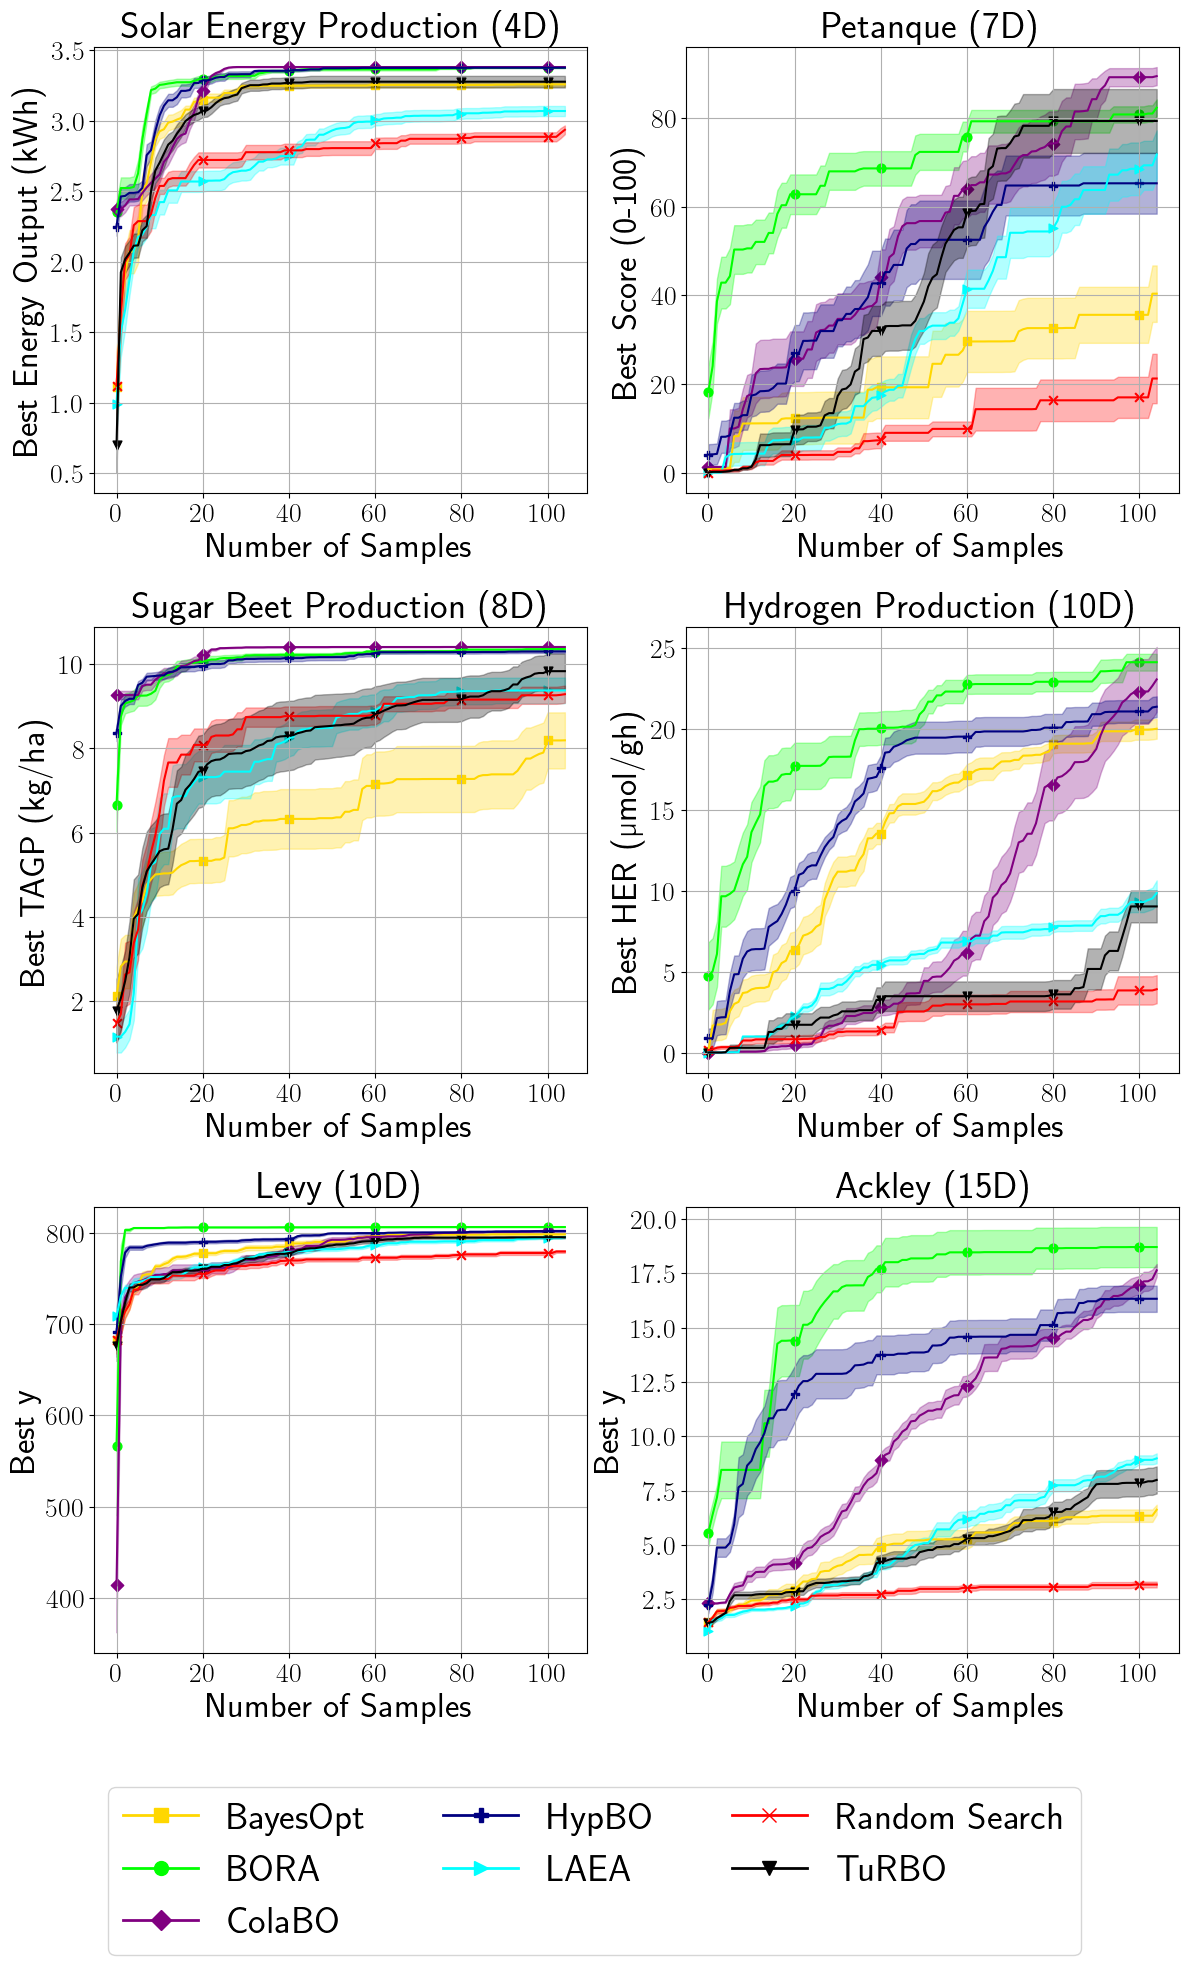

In [8]:
def plot_full_results(
    experiments: List[Tuple[str, str]],
    data_folder_path: str = "data",
    exclude_models: List[str] = ["LAEA_5", "LLM-Only"],
):

    # Prepare ax with a single row and multiple columns
    fig, axs = plt.subplots(3, 2, figsize=(7 * 2, 22))
    # Adjust the spacing between subplots
    plt.subplots_adjust(
        hspace=0.3)  # Adjust hspace to add more space between rows

    font_size = 25

    # Record the models that are found for the legend creation
    found_models = []

    for i, (experiment_name, label) in enumerate(experiments):
        # Get the experiment folder
        experiment_folder = os.path.join(data_folder_path, experiment_name)

        # Check if the experiment folder exists
        if not os.path.exists(experiment_folder):
            print(f"No experiment folder found for {experiment_name}")
            continue

        # Find the models applied for the experiment
        models = [
            f for f in os.listdir(experiment_folder)
            if os.path.isdir(os.path.join(experiment_folder, f))
            and f not in exclude_models
        ]

        # Plot the results
        for model in models:
            if model not in STYLE_DICT:
                print(f"Model {model} not in style_dict")
                continue
            data_folder = os.path.join(
                data_folder_path,
                experiment_name,
                model,
            )
            color = STYLE_DICT[model]["color"]
            marker = STYLE_DICT[model]["marker"]

            # Check if summary file exists
            summary_file = os.path.join(data_folder,
                                        f"summary_{experiment_name}.csv")
            if not os.path.exists(summary_file):
                print(
                    f"No summary file found for {experiment_name} and {model}")
                continue

            # Add the model to the found models
            if model not in found_models:
                found_models.append(model)

            # Plot the data
            ax_i = i // 2
            ax_j = i % 2
            plot_data(
                axs[ax_i, ax_j],
                data_folder,
                experiment_name,
                color,
                marker,
                False,
            )

        axs[ax_i, ax_j].set_xlabel("Number of Samples")
        axs[ax_i, ax_j].set_ylabel(f"Best {label}")

        # Title
        experiment_name = experiment_name if experiment_name not in RENAMES else RENAMES[
            experiment_name]
        experiment_name, dim = experiment_name.split("_d")
        title = f"{experiment_name} ({dim}D)"
        axs[ax_i, ax_j].set_title(title)

        axs[ax_i, ax_j].grid()

        # Increase the font size
        for item in (axs[ax_i, ax_j].get_xticklabels() +
                     axs[ax_i, ax_j].get_yticklabels()):
            item.set_fontsize(int(font_size * 0.8))

        for item in [axs[ax_i, ax_j].xaxis.label, axs[ax_i, ax_j].yaxis.label]:
            item.set_fontsize(font_size)

        axs[ax_i, ax_j].title.set_fontsize(int(1.1 * font_size))

    # Add Legend
    # Create Custom Legend
    custom_legend_handles = []
    labels = []
    for model in found_models:
        handle = Line2D([0], [0],
                        color=STYLE_DICT[model]["color"],
                        lw=2,
                        marker=STYLE_DICT[model]["marker"],
                        markersize=10,
                        label=model)

        label = model
        labels.append(label)
        custom_legend_handles.append(handle)

    # Create a single legend
    ncol = 3

    fig.legend(custom_legend_handles,
               labels,
               loc='lower center',
               ncol=ncol,
               fontsize=int(1.1 * font_size))

    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.15)


plot_full_results(experiments_labels, data_dir)

## Focusing on the cumulative regrets at the end of the optimization.


In [9]:
def generate_cumulative_regret_summary(
    experiments,
    models,
    data_folder_path: str,
    n_samples: int = 55,
):
    cumulative_regrets = pd.DataFrame(experiments, columns=["experiment"])
    cumulative_regrets = cumulative_regrets.assign(
        **{model: [None] * len(experiments)
           for model in models})

    for experiment in experiments:
        for model in models:
            summary_folder = os.path.join(data_folder_path, experiment, model,
                                          f"summary_{experiment}.csv")
            if not os.path.exists(summary_folder):
                cumulative_regrets.loc[cumulative_regrets["experiment"] ==
                                       experiment, model] = None
            else:
                data = pd.read_csv(summary_folder)
                cumulative_regret = data["mean_cum_regret"].values[n_samples -
                                                                   1]
                cumulative_regrets.loc[cumulative_regrets["experiment"] ==
                                       experiment, model] = cumulative_regret

    # Rename experiments for better readability for the paper.
    for original_name, name_in_paper in RENAMES.items():
        cumulative_regrets["experiment"] = cumulative_regrets[
            "experiment"].replace(original_name, name_in_paper)

    return cumulative_regrets

In [10]:
experiments = [e for e, l in experiments_labels]
models = [
    "BORA", "HypBO", "ColaBO", "BayesOpt", "TuRBO", "LAEA", "Random Search"
]
cumulative_regrets = generate_cumulative_regret_summary(experiments,
                                                        models,
                                                        data_dir,
                                                        n_samples=105)
cumulative_regrets

,experiment,BORA,HypBO,ColaBO,BayesOpt,TuRBO,LAEA,Random Search
0,Solar Energy Production_d4,9.383,11.721,14.639,27.279,28.343,62.04,67.74
1,Petanque_d7,3203.532,5691.354,4933.564,8139.811,5850.086,7020.745,9475.734
2,Sugar Beet Production_d8,31.759,32.968,16.126,418.744,241.437,253.326,222.803
3,Hydrogen Production_d10,1401.497,1801.4401,2647.638,2054.475882,3134.58,2905.84,3252.444
4,Levy_d10,346.757505,1263.277405,2921.777005,2302.877605,2993.043805,3070.252405,4307.911805
5,Ackley_d15,582.238582,908.008682,1223.311982,1801.777682,1795.340882,1761.163782,2010.326982


### Let's generate the bar plots


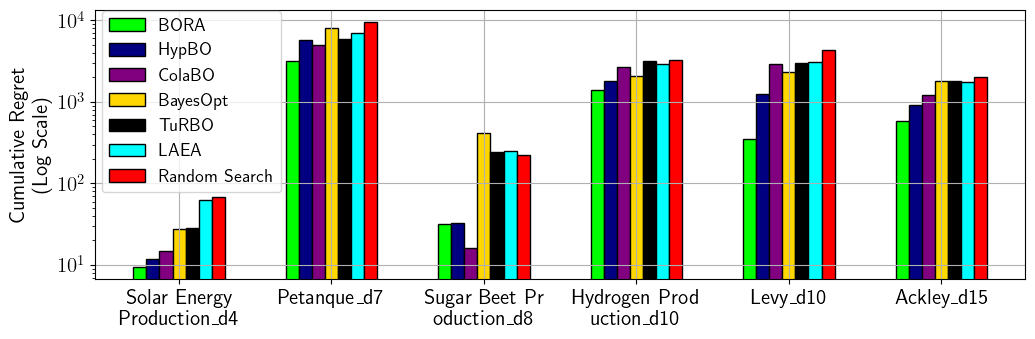

In [11]:
def plot_cumulative_regrets(cumulative_regrets):
    """Bar plot of the cumulative regrets for the experiments."""
    fig, ax = plt.subplots(figsize=(12, 3.5))
    font_size = 15
    colors = [
        STYLE_DICT[col]["color"] for col in cumulative_regrets.columns
        if col != "experiment"
    ]
    cumulative_regrets.set_index("experiment").plot(kind="bar",
                                                    ax=ax,
                                                    color=colors,
                                                    width=0.6,
                                                    edgecolor='black')
    ax.set_ylabel("Cumulative Regret\n(Log Scale)")
    ax.set_yscale("log")
    ax.grid()
    # Remove the x-axis label
    ax.set_xlabel("")

    # Adjust x-axis labels
    labels = ax.get_xticklabels()
    new_labels = []
    line_length = 13
    for label in labels:
        text = label.get_text()
        new_text = '\n'.join([
            text[i:i + line_length] for i in range(0, len(text), line_length)
        ])
        new_labels.append(new_text)

    ax.set_xticklabels(new_labels, rotation=0)

    # Increase the font size
    for item in ([ax.title, ax.yaxis.label] + ax.get_xticklabels() +
                 ax.get_yticklabels()):
        item.set_fontsize(font_size)
    ax.legend(bbox_to_anchor=(0.21, 0.29), fontsize=int(0.9 * font_size))


plot_cumulative_regrets(cumulative_regrets)


# Comporaing BORA to the LLM-only optimizer


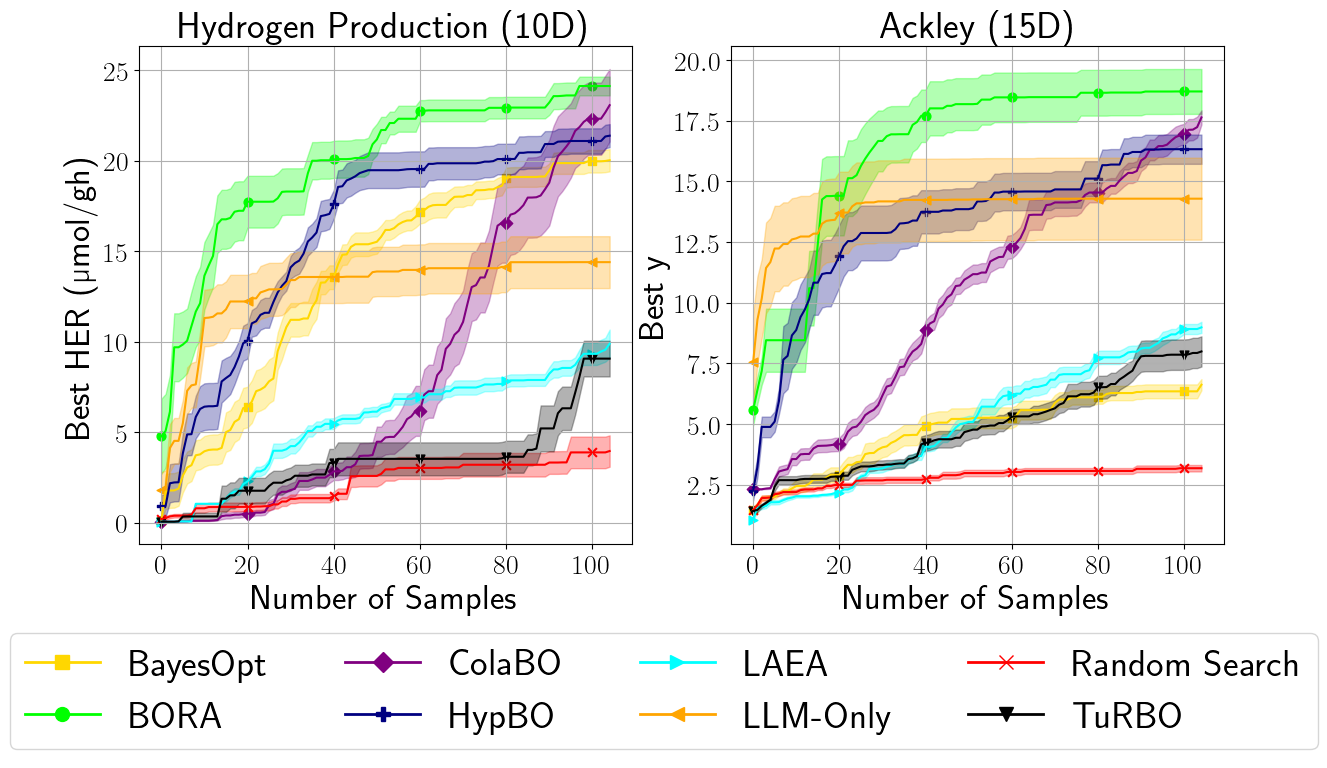

In [12]:
_experiments = [
    ("Photocatalytic Hydrogen Production_d10", "HER (µmol/gh)"),
    ("Ackley_d15", "y"),
]

plot_results(_experiments, data_dir, exclude_models=["LAEA_5"], limit=False)

# Investigating LAEA's performance with two different population sizes: 5 vs 15


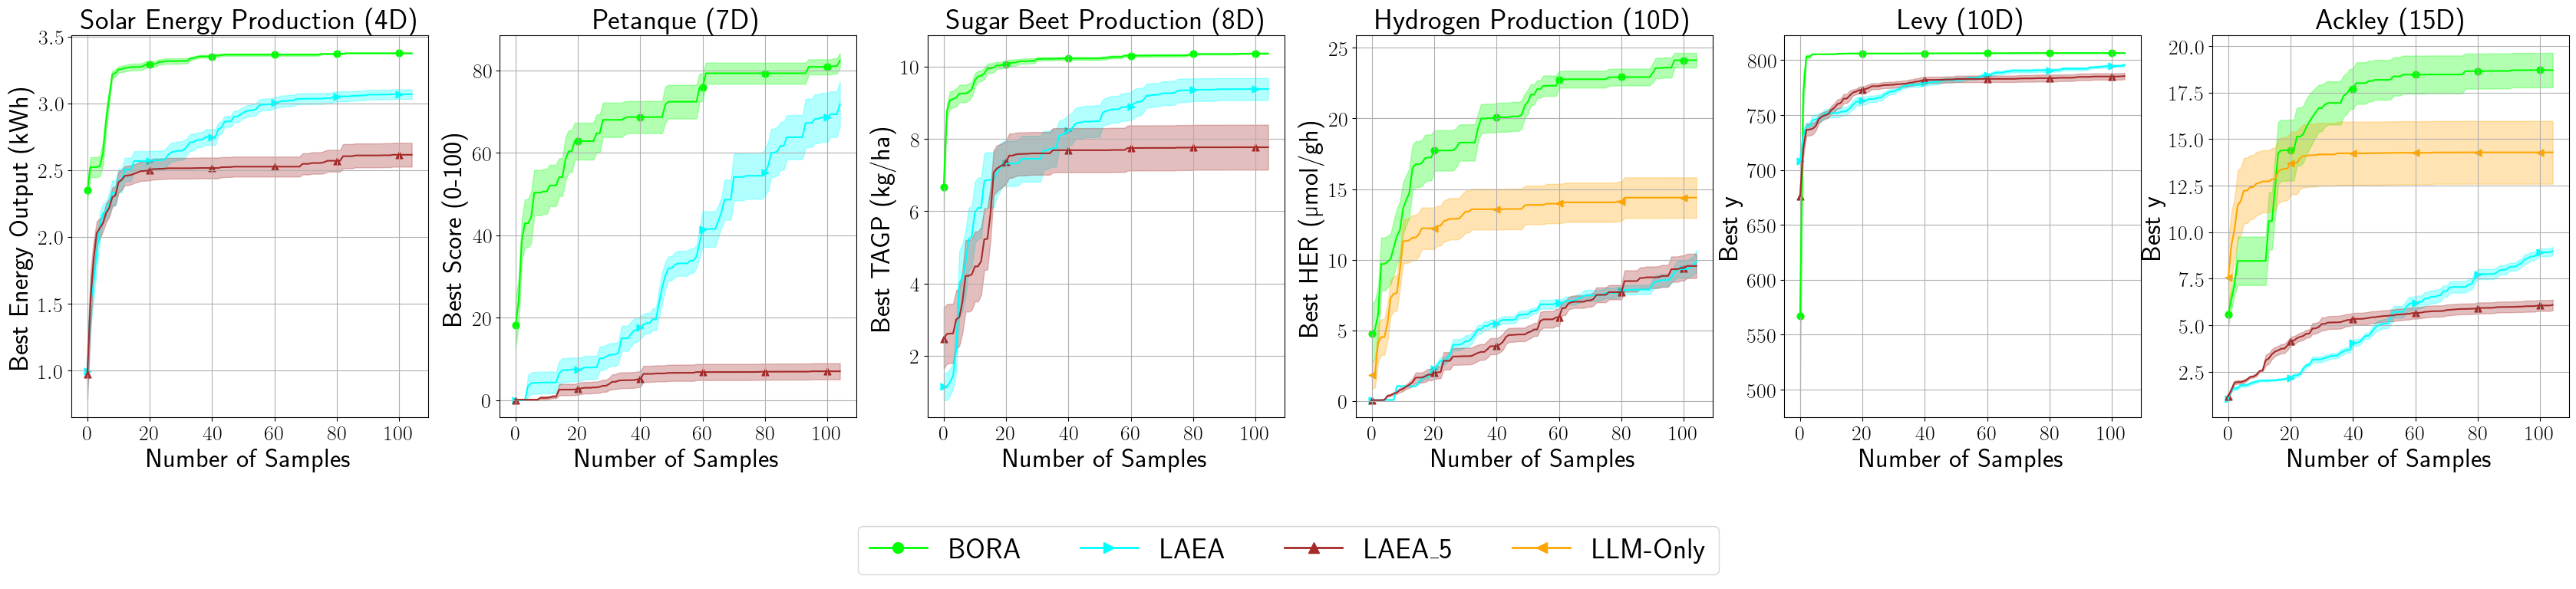

In [13]:
plot_results(experiments_labels,
             data_dir,
             exclude_models=[
                 "HypBO", "ColaBO", "Random Search", "BayesOpt", "LLM", "TuRBO"
             ],
             limit=False)

# Comparing the cost of BORA vs LAEA runs

The cost of the LAEA runs were reported from our OpenAI billing account and amounts to about 41 USD.


In [14]:
from data.utils import get_bora_experiment_cost

# Calculate the cost of the BORA runs
total_cost = 0
for experiment in experiments:
    experiment_dir = os.path.join(data_dir, experiment, "BORA")
    total_cost += get_bora_experiment_cost(experiment_dir)

print(f"Total cost of BORA runs across all experiments: ${total_cost:.2f} USD")


Total cost of BORA runs across all experiments: $4.37 USD


# m_{init} Ablation Studies


Model BORA_m_init_16 not in style_dict


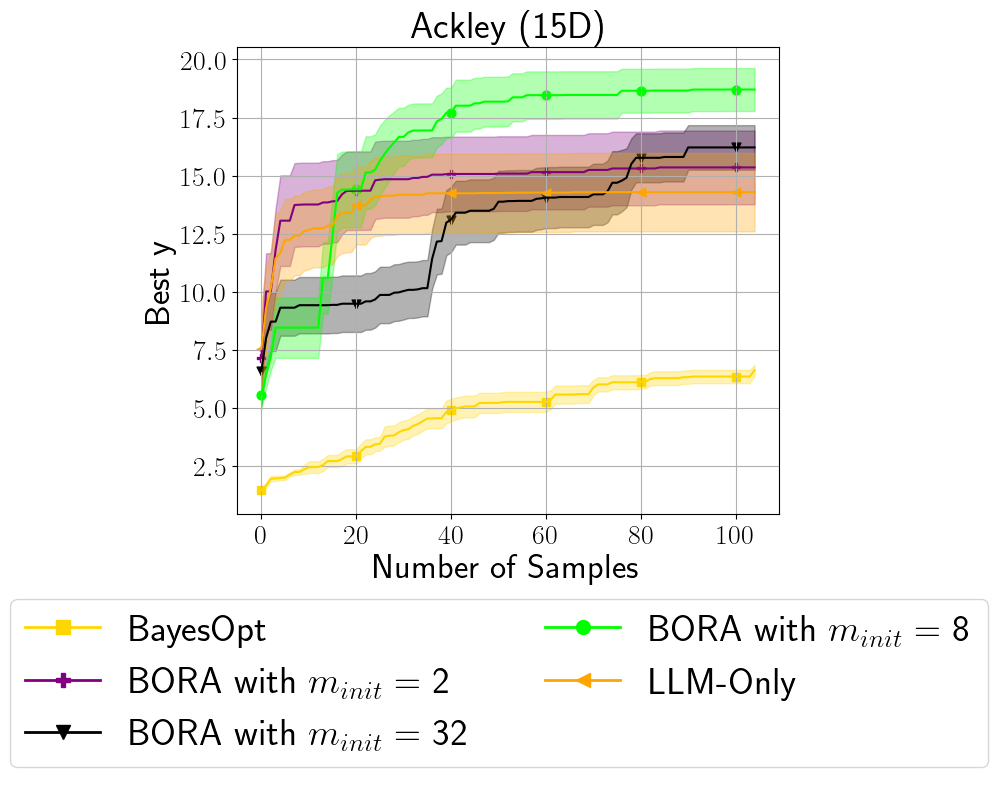

In [17]:
ablation_data_dir = os.path.join("data", "ablation_studies")
_experiments = [
    ("Ackley_d15", "y"),
]

# Update the summary files for the ablation studies
for experiment, _ in _experiments:
    recalculate_summary_file(ablation_data_dir, experiment)

ABLATION_DICT = {
    "BORA_m_init_2": {
        "color": "purple",
        "marker": "P",
    },
    "BORA_m_init_8": {
        "color": "lime",
        "marker": "o",
    },
    "BORA_m_init_32": {
        "color": "black",
        "marker": "v",
    },
    "BayesOpt": {
        "color": "gold",
        "marker": "s",
    },
    "LLM-Only": {
        "color": "orange",
        "marker": "<",
    },
}

# Merging the dictionaries
STYLE_DICT.update(ABLATION_DICT)


def plot_abation_result(experiments: List[Tuple[str, str]],
                        data_folder_path: str = "data"):

    # Prepare ax with a single row and multiple columns
    fig, axs = plt.subplots(1,
                            len(experiments),
                            figsize=(7 * len(experiments), 8.5))  # 6.1
    # Ensure axs is always an array
    axs = np.atleast_1d(axs)

    font_size = 25

    # Record the models that are found for the legend creation
    found_models = []
    for i, (experiment_name, label) in enumerate(experiments):
        # Get the experiment folder
        experiment_folder = os.path.join(data_folder_path, experiment_name)

        # Check if the experiment folder exists
        if not os.path.exists(experiment_folder):
            print(f"No experiment folder found for {experiment_name}")
            continue

        # Find the models applied for the experiment
        models = [
            f for f in os.listdir(experiment_folder)
            if os.path.isdir(os.path.join(experiment_folder, f))
        ]

        # Plot the results
        for model in models:
            if model not in STYLE_DICT:
                print(f"Model {model} not in style_dict")
                continue
            data_folder = os.path.join(
                data_folder_path,
                experiment_name,
                model,
            )
            color = STYLE_DICT[model]["color"]
            marker = STYLE_DICT[model]["marker"]

            # Check if summary file exists
            summary_file = os.path.join(data_folder,
                                        f"summary_{experiment_name}.csv")
            if not os.path.exists(summary_file):
                print(
                    f"No summary file found for {experiment_name} and {model}")
                continue

            # Add the model to the found models
            if model not in found_models:
                found_models.append(model)

            # Plot the data
            plot_data(
                axs[i],
                data_folder,
                experiment_name,
                color,
                marker,
                False,
            )

        axs[i].set_xlabel("Number of Samples")
        axs[i].set_ylabel(f"Best {label}")

        # Title
        experiment_name = experiment_name if experiment_name not in RENAMES else RENAMES[
            experiment_name]
        experiment_name, dim = experiment_name.split("_d")
        title = f"{experiment_name} ({dim}D)"
        axs[i].set_title(title)

        axs[i].grid()

        # Increase the font size
        for item in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            item.set_fontsize(int(font_size * 0.8))

        for item in [axs[i].xaxis.label, axs[i].yaxis.label]:
            item.set_fontsize(font_size)

        axs[i].title.set_fontsize(int(1.1 * font_size))

    # Add Legend
    # Create Custom Legend
    custom_legend_handles = []
    labels = []
    for model in found_models:
        handle = Line2D([0], [0],
                        color=STYLE_DICT[model]["color"],
                        lw=2,
                        marker=STYLE_DICT[model]["marker"],
                        markersize=10,
                        label=model)

        label = model
        if "BORA_" in model:
            label = label.replace("BORA_", "BORA with ")
            label = label.replace("m_init_", "$ m_{init} =\ $")
        labels.append(label)
        custom_legend_handles.append(handle)

    # Create a single legend
    ncol = len(labels) if len(experiments) > 5 else 4

    # Update the number of columns for the Ablation Study plot
    for model in models:
        if "BORA_" in model:
            ncol = 2
            break

    fig.legend(custom_legend_handles,
               labels,
               loc='lower center',
               ncol=ncol,
               fontsize=int(1.1 * font_size))

    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.33)  # 0.34


plot_abation_result(_experiments, ablation_data_dir)